# AQI Prediction with LSTM - Corrected Version
## Changes from stock tutorial:
1. Use average AQI from multiple sensors OR single sensor
2. Handle missing dates in time series
3. Same LSTM architecture works fine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc

## Load and Prepare Data

In [12]:
# Your existing data loading code
df = pd.read_csv('data.csv')

# Your date fixing code
df['temp_date'] = pd.to_datetime(df['Date'].astype(str) + '-2020', format='%d-%b-%Y')
years = []
current_year = 2017
prev_month = 3  

for idx, row in df.iterrows():
    current_month = row['temp_date'].month
    if current_month < prev_month:
        current_year += 1
    years.append(current_year)
    prev_month = current_month

df['Year'] = years

# Extract "-MM-DD" from temp_date and prepend the Year column
date_strings = df['Year'].astype(str) + df['temp_date'].dt.strftime('-%m-%d')

# Convert the combined string back to datetime
df['Date'] = pd.to_datetime(date_strings)
df.set_index('Date', inplace=True)
df.drop(['temp_date', 'Year'], axis=1, inplace=True)

In [13]:
df

,1,2,3,4,5,6,7,8,9,10,...,7723955,30369354,34703847,36200067,36671067,37052366,38834077,39168240,39379024,Grand Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-22,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92
2017-03-23,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85
2017-03-24,208.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126
2017-03-25,68.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
2017-03-26,46.0,48.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-03,NaN,47.0,NaN,NaN,26.0,28.0,74.0,NaN,25.0,NaN,...,NaN,30.0,NaN,67.0,39.0,28.0,27.0,116.0,34.0,42
2020-10-04,NaN,30.0,NaN,NaN,18.0,21.0,104.0,NaN,21.0,NaN,...,NaN,25.0,6.0,40.0,30.0,28.0,23.0,61.0,NaN,32
2020-10-05,NaN,30.0,NaN,NaN,17.0,20.0,75.0,NaN,18.0,NaN,...,NaN,24.0,NaN,37.0,29.0,23.0,20.0,67.0,NaN,31


In [14]:
# Keep only stable sensors
stable_sensors = ['2', '5', '6', '9', '12']
df_sensors = df[stable_sensors]

# Fill missing values
df_sensors = df_sensors.interpolate(method='linear').fillna(method='bfill')

# IMPORTANT: Make it daily frequency
df_sensors = df_sensors.asfreq('D')
df_sensors = df_sensors.interpolate(method='linear')

/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T/ipykernel_1640/3363375190.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sensors = df_sensors.interpolate(method='linear').fillna(method='bfill')


## CHANGE 1: Choose your approach

### Option A: Use AVERAGE of all sensors (RECOMMENDED)
This gives you a more robust overall AQI measure

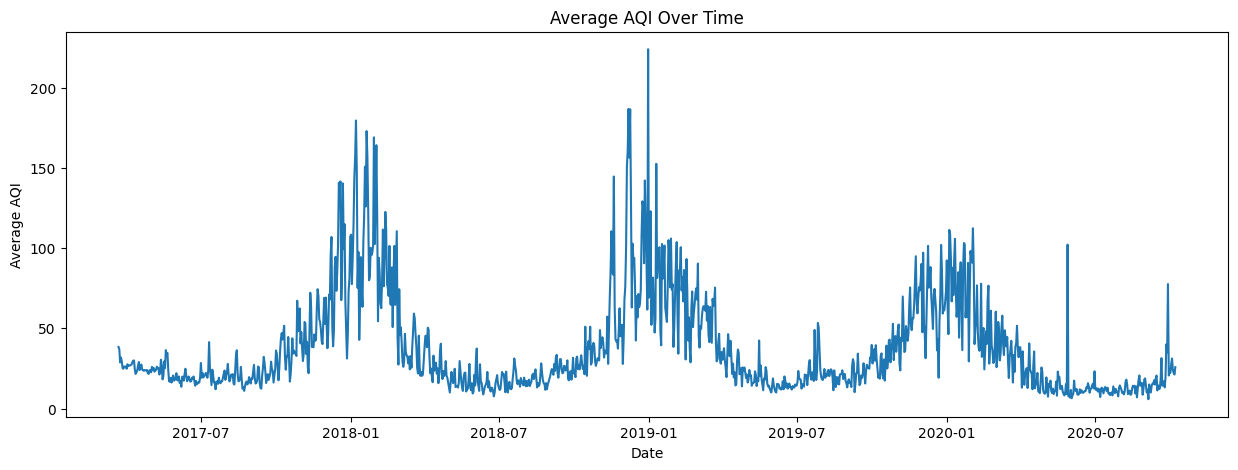

In [15]:
# Option A: Average AQI across all sensors
data = pd.DataFrame()
data['AQI'] = df_sensors.mean(axis=1)  # Average across sensors

plt.figure(figsize=(15, 5))
plt.plot(data.index, data['AQI'])
plt.xlabel('Date')
plt.ylabel('Average AQI')
plt.title('Average AQI Over Time')
plt.show()

### Option B: Use single sensor (Alternative)

In [16]:
# Option B: Single sensor (comment out if using Option A)
# data = pd.DataFrame()
# data['AQI'] = df_sensors['2']  # Use sensor 2

## CHANGE 2: Modified prepare function for AQI
Same concept as stock prices, but clearer naming

In [17]:
def prepare_dataframe_for_lstm(df, n_steps):
    """
    Prepare time series data for LSTM by creating lagged features
    
    Args:
        df: DataFrame with AQI column
        n_steps: number of past time steps to use (lookback window)
    
    Returns:
        DataFrame with current AQI and lagged features
    """
    df = dc(df)
    
    # Create lagged features
    for i in range(1, n_steps + 1):
        df[f'AQI(t-{i})'] = df['AQI'].shift(i)
    
    # Drop rows with NaN (first n_steps rows)
    df.dropna(inplace=True)
    
    return df

# Use 7 days lookback (you can experiment with this)
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)

print(f"Original data shape: {data.shape}")
print(f"After creating lagged features: {shifted_df.shape}")
shifted_df.head(10)

Original data shape: (1296, 1)
After creating lagged features: (1289, 8)


,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6),AQI(t-7)
Date,,,,,,,,
2017-03-29,26.20,24.80,25.20,29.60,31.8,28.8,37.0,38.4
2017-03-30,26.00,26.20,24.80,25.20,29.6,31.8,28.8,37.0
2017-03-31,26.20,26.00,26.20,24.80,25.2,29.6,31.8,28.8
2017-04-01,24.80,26.20,26.00,26.20,24.8,25.2,29.6,31.8
2017-04-02,27.60,24.80,26.20,26.00,26.2,24.8,25.2,29.6
2017-04-03,26.40,27.60,24.80,26.20,26.0,26.2,24.8,25.2
2017-04-04,26.65,26.40,27.60,24.80,26.2,26.0,26.2,24.8
2017-04-05,26.90,26.65,26.40,27.60,24.8,26.2,26.0,26.2
2017-04-06,27.15,26.90,26.65,26.40,27.6,24.8,26.2,26.0


## From here, the code is EXACTLY the same as stock tutorial

In [18]:
# Convert to numpy
shifted_df_as_np = shifted_df.to_numpy()
print("Shape:", shifted_df_as_np.shape)
print("First row:", shifted_df_as_np[0])

Shape: (1289, 8)
First row: [26.2 24.8 25.2 29.6 31.8 28.8 37.  38.4]


In [19]:
# Normalize data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

print("After normalization:")
print(shifted_df_as_np[:5])

After normalization:
[[-0.81305842 -0.82588774 -0.82222222 -0.78190149 -0.76174112 -0.78923253
  -0.71408935 -0.70126002]
 [-0.81489118 -0.81305842 -0.82588774 -0.82222222 -0.78190149 -0.76174112
  -0.78923253 -0.71408935]
 [-0.81305842 -0.81489118 -0.81305842 -0.82588774 -0.82222222 -0.78190149
  -0.76174112 -0.78923253]
 [-0.82588774 -0.81305842 -0.81489118 -0.81305842 -0.82588774 -0.82222222
  -0.78190149 -0.76174112]
 [-0.8002291  -0.82588774 -0.81305842 -0.81489118 -0.81305842 -0.82588774
  -0.82222222 -0.78190149]]


In [20]:
# Split into X (features) and y (target)
X = shifted_df_as_np[:, 1:]  # All columns except first (lagged values)
y = shifted_df_as_np[:, 0]   # First column (current AQI)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1289, 7)
y shape: (1289,)


In [21]:
# Flip X to have chronological order (oldest to newest)
X = dc(np.flip(X, axis=1))
print("First sample features (t-7 to t-1):")
print(X[0])

First sample features (t-7 to t-1):
[-0.70126002 -0.71408935 -0.78923253 -0.76174112 -0.78190149 -0.82222222
 -0.82588774]


In [22]:
# Train/test split (95% train, 5% test)
split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 1224
Testing samples: 65


In [23]:
# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print("After reshaping:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

After reshaping:
X_train: (1224, 7, 1)
X_test: (65, 7, 1)
y_train: (1224, 1)
y_test: (65, 1)


In [24]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print("Converted to PyTorch tensors")

Converted to PyTorch tensors


In [25]:
# Create Dataset class
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [26]:
# Create DataLoaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 77
Number of test batches: 5


## LSTM Model - Same as stock tutorial

In [27]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [28]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Create model
model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1)
model.to(device)

print(model)

Using device: cpu
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
# Training setup
learning_rate = 0.001
num_epochs = 100

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
# Training loop
def train_one_epoch():
    model.train()
    running_loss = 0.0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

# Validation function
def validate():
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            running_loss += loss.item()
    
    return running_loss / len(test_loader)

In [31]:
# Train the model
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch()
    val_loss = validate()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

Epoch 1/10, Train Loss: 0.584211, Val Loss: 0.554712
Epoch 2/10, Train Loss: 0.234417, Val Loss: 0.126358
Epoch 3/10, Train Loss: 0.061652, Val Loss: 0.026229
Epoch 4/10, Train Loss: 0.048255, Val Loss: 0.021050
Epoch 5/10, Train Loss: 0.044377, Val Loss: 0.019191
Epoch 6/10, Train Loss: 0.041442, Val Loss: 0.014852
Epoch 7/10, Train Loss: 0.037254, Val Loss: 0.012947
Epoch 8/10, Train Loss: 0.033916, Val Loss: 0.010912
Epoch 9/10, Train Loss: 0.030962, Val Loss: 0.010503
Epoch 10/10, Train Loss: 0.028384, Val Loss: 0.011205


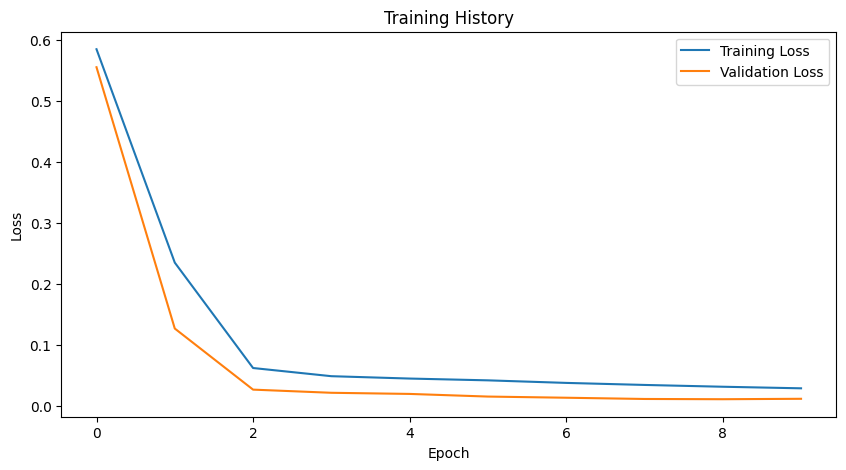

In [32]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

## Make Predictions

In [33]:
# Get predictions on training set
with torch.no_grad():
    train_predictions = model(X_train.to(device)).cpu().numpy()
    train_predictions = scaler.inverse_transform(
        np.concatenate((train_predictions, np.zeros((len(train_predictions), lookback))), axis=1)
    )[:, 0]
    
    # Get actual training values
    y_train_actual = scaler.inverse_transform(
        np.concatenate((y_train.numpy(), np.zeros((len(y_train), lookback))), axis=1)
    )[:, 0]

In [34]:
# Get predictions on test set
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    test_predictions = scaler.inverse_transform(
        np.concatenate((test_predictions, np.zeros((len(test_predictions), lookback))), axis=1)
    )[:, 0]
    
    # Get actual test values
    y_test_actual = scaler.inverse_transform(
        np.concatenate((y_test.numpy(), np.zeros((len(y_test), lookback))), axis=1)
    )[:, 0]

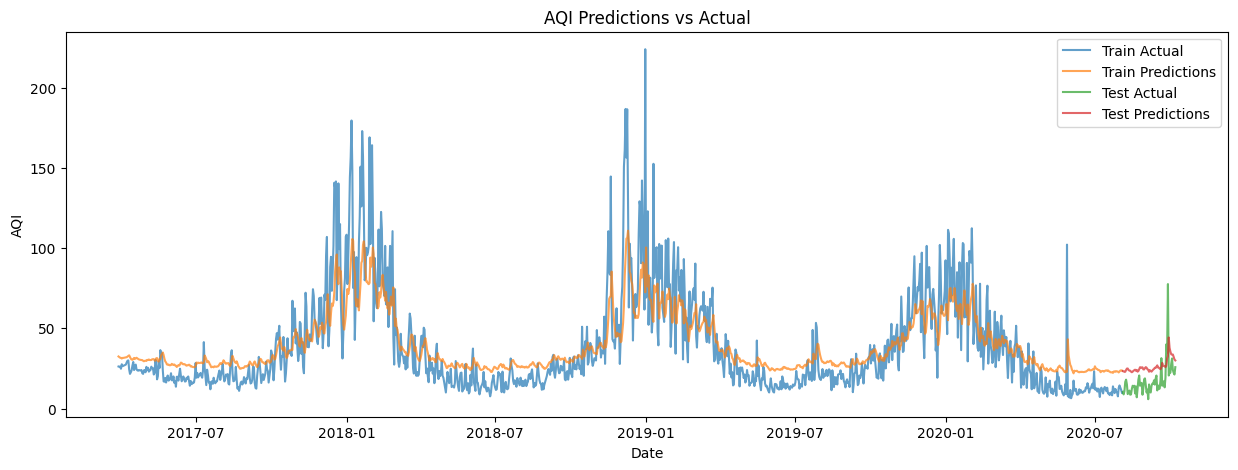

In [35]:
# Plot results
plt.figure(figsize=(15, 5))

# Get dates for plotting
train_dates = shifted_df.index[:split_index]
test_dates = shifted_df.index[split_index:]

plt.plot(train_dates, y_train_actual, label='Train Actual', alpha=0.7)
plt.plot(train_dates, train_predictions, label='Train Predictions', alpha=0.7)
plt.plot(test_dates, y_test_actual, label='Test Actual', alpha=0.7)
plt.plot(test_dates, test_predictions, label='Test Predictions', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI Predictions vs Actual')
plt.legend()
plt.show()

In [36]:
# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_mae = mean_absolute_error(y_train_actual, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
train_r2 = r2_score(y_train_actual, train_predictions)

test_mae = mean_absolute_error(y_test_actual, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
test_r2 = r2_score(y_test_actual, test_predictions)

print("Training Metrics:")
print(f"  MAE: {train_mae:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  R²: {train_r2:.4f}")
print("\nTest Metrics:")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R²: {test_r2:.4f}")

Training Metrics:
  MAE: 12.80
  RMSE: 18.12
  R²: 0.6515

Test Metrics:
  MAE: 11.24
  RMSE: 12.66
  R²: -0.5908


## Future Predictions (Optional)
Predict next N days

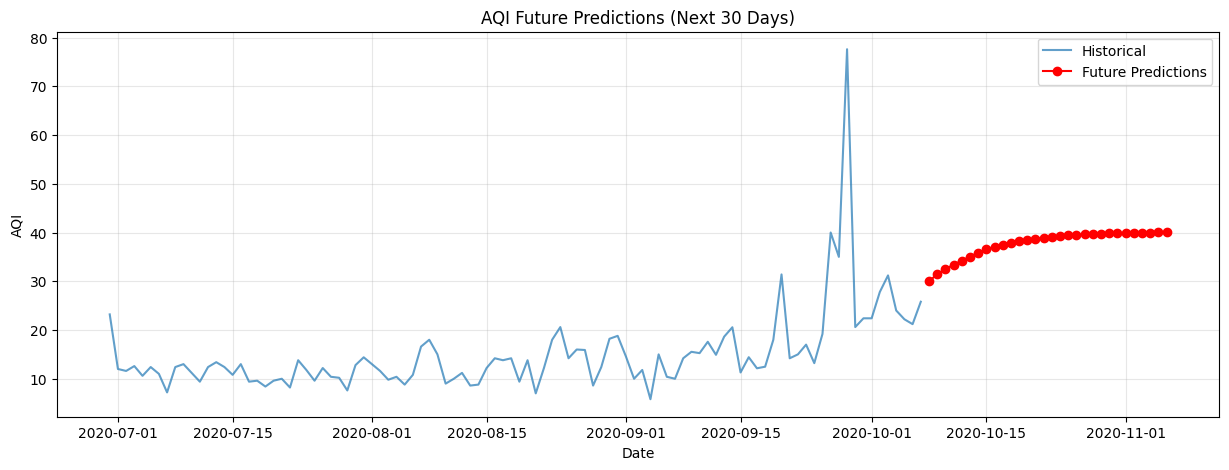


Future AQI Predictions:
2020-10-08: 29.99
2020-10-09: 31.44
2020-10-10: 32.50
2020-10-11: 33.40
2020-10-12: 34.21
2020-10-13: 35.06
2020-10-14: 35.85
2020-10-15: 36.55
2020-10-16: 37.06
2020-10-17: 37.50


In [37]:
def predict_future(model, last_sequence, n_future, scaler, device):
    """
    Predict future AQI values
    
    Args:
        model: trained LSTM model
        last_sequence: last 'lookback' days of normalized data
        n_future: number of days to predict
        scaler: fitted MinMaxScaler
        device: torch device
    """
    model.eval()
    predictions = []
    current_sequence = last_sequence.copy()
    
    with torch.no_grad():
        for _ in range(n_future):
            # Prepare input
            x = torch.tensor(current_sequence).float().reshape(1, lookback, 1).to(device)
            
            # Predict
            pred = model(x).cpu().numpy()[0, 0]
            predictions.append(pred)
            
            # Update sequence (remove oldest, add newest)
            current_sequence = np.append(current_sequence[1:], pred)
    
    # Inverse transform
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(
        np.concatenate((predictions, np.zeros((len(predictions), lookback))), axis=1)
    )[:, 0]
    
    return predictions

# Get last sequence from test set
last_sequence = X_test[-1].cpu().numpy().flatten()

# Predict next 30 days
future_predictions = predict_future(model, last_sequence, 30, scaler, device)

# Create future dates
last_date = shifted_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(shifted_df.index[-100:], shifted_df['AQI'].values[-100:], label='Historical', alpha=0.7)
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI Future Predictions (Next 30 Days)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nFuture AQI Predictions:")
for date, pred in zip(future_dates[:10], future_predictions[:10]):
    print(f"{date.strftime('%Y-%m-%d')}: {pred:.2f}")